In [1]:
import io
import json
import os
import time
from datetime import datetime
from timeit import default_timer as timer

import polars as pl
import requests
import tqdm.notebook as tqdm
from dateutil.relativedelta import relativedelta
from dotenv import find_dotenv, load_dotenv
from groq import Groq

load_dotenv(find_dotenv())

# Load API keys from environment...
acled_api_key = os.getenv("ACLED_API_KEY")
acled_email = os.getenv("ACLED_EMAIL")
groq_api_key = os.getenv("GROQ_API_KEY")

# ...or enter them manually
if not acled_api_key:
    acled_api_key = input("Enter your ACLED API key: ")
    os.environ["ACLED_API_KEY"] = acled_api_key

if not acled_email:
    acled_email = input("Enter your ACLED email: ")
    os.environ["ACLED_EMAIL"] = acled_email

if not groq_api_key:
    groq_api_key = input("Enter your Groq API key: ")
    os.environ["GROQ_API_KEY"] = groq_api_key

In [2]:
# Choose a country to analyze
country = "Afghanistan" # global variable

# Forward Outlook (CAST)

In [3]:
# Set up API parameters
parameters = {
    "email": acled_email,
    "key": acled_api_key,
    "country": country,
}

# GET request to ACLED API
response = requests.get("https://api.acleddata.com/cast/read.csv", params=parameters)
response.raise_for_status()

cast = pl.read_csv(io.BytesIO(response.content))
#cast = cast.filter(pl.col("country") != "South Sudan")

month_map = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

cast = (
    cast.with_columns(pl.col("month").replace(month_map).alias("month_num"))
    .with_columns(
        (
            pl.col("year").cast(str) + "-" + pl.col("month_num").cast(str).str.zfill(2)
        ).alias("year_month")
    )
    .drop("month_num")
)


print(f"Retrieved {cast.height} events from ACLED API")
print(cast.head())

# # Save to file
# country = parameters["country"].replace(" ", "_").lower()
# filename = f"{country}_cast.csv"
# cast.write_csv(filename)
# print(f"Data saved as '{filename}'")

Retrieved 1122 events from ACLED API
shape: (5, 14)
┌─────────────┬─────────┬───────────┬──────┬───┬────────────┬────────────┬────────────┬────────────┐
│ country     ┆ admin1  ┆ month     ┆ year ┆ … ┆ erv_observ ┆ vac_observ ┆ timestamp  ┆ year_month │
│ ---         ┆ ---     ┆ ---       ┆ ---  ┆   ┆ ed         ┆ ed         ┆ ---        ┆ ---        │
│ str         ┆ str     ┆ str       ┆ i64  ┆   ┆ ---        ┆ ---        ┆ i64        ┆ str        │
│             ┆         ┆           ┆      ┆   ┆ i64        ┆ i64        ┆            ┆            │
╞═════════════╪═════════╪═══════════╪══════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ Afghanistan ┆ Helmand ┆ June      ┆ 2025 ┆ … ┆ null       ┆ null       ┆ 1749732000 ┆ 2025-06    │
│ Afghanistan ┆ Helmand ┆ July      ┆ 2025 ┆ … ┆ null       ┆ null       ┆ 1749732000 ┆ 2025-07    │
│ Afghanistan ┆ Helmand ┆ August    ┆ 2025 ┆ … ┆ null       ┆ null       ┆ 1749732000 ┆ 2025-08    │
│ Afghanistan ┆ Helmand ┆ September ┆ 2

### Calculate average number of events for 1, 3, 6 and 12 months from the current date

In [4]:
def create_rolling_averages(cast):
    cast = cast.with_columns(
        pl.col("year_month").str.strptime(pl.Date, "%Y-%m").alias("year_month_dt")
    ).sort(["admin1", "year_month_dt"])

    window_sizes = [1, 3, 6, 12]

    for window in window_sizes:
        avg_col = []
        rows = cast.to_dicts()

        data_dict = {}
        for row in rows:
            key = (row["admin1"], row["year_month_dt"])
            data_dict[key] = row["total_observed"]

        for row in rows:
            admin = row["admin1"]
            current_date = row["year_month_dt"]

            values = []
            for i in range(1, window + 1):
                check_date = current_date - relativedelta(months=i)
                key = (admin, check_date)
                if key in data_dict and data_dict[key] is not None:
                    values.append(data_dict[key])

            if values:
                avg_val = sum(values) / len(values)
            else:
                avg_val = None

            avg_col.append(avg_val)

        cast = cast.with_columns(pl.Series(name=f"avg{window}", values=avg_col))

    return cast.with_columns(
        pl.col("year_month_dt").dt.strftime("%Y-%m").alias("year_month")
    ).drop("year_month_dt")


cast_clean = create_rolling_averages(cast)

### Calculate percent increase of predicted events (compared to observed events in the most recent month). Tag as 1 if the percentage is greater than 25.

In [5]:
cast_clean = cast_clean.with_columns(
    pl.col(["avg1", "avg3", "avg6", "avg12"]).fill_null(strategy="forward")
)

cast_clean = cast_clean.with_columns(pl.col("total_observed").fill_null(0))

windows = [1, 3, 6, 12]
for w in windows:
    percent_col = f"percent_increase{w}"
    hot_col = f"hotspot{w}"
    cast_clean = cast_clean.with_columns(
        pl.when(
            (pl.col(f"avg{w}") == 0) & (pl.col("total_forecast") > 0)
        )  # Handle "inf" increase when average observed events = 0, and forecasted events > 0
        .then(pl.col("total_forecast") * 10)
        .otherwise(
            (pl.col("total_forecast") - pl.col(f"avg{w}")) / pl.col(f"avg{w}") * 100
        )
        .fill_null(0)
        .fill_nan(0)
        .alias(percent_col)
    ).with_columns((pl.col(percent_col) >= 25).cast(pl.Int8).alias(hot_col))

## Retreive "hotspots" for the selected horizon

In [6]:
# Parameters
window = 1 # Number of past month to calculate average # of events
hot_col = f"hotspot{window}"
horizon = 2 # Number of months ahead from current month to check for hotspots (if "hotspot1"==1)

# Get current month and calculate target months
current_date = datetime.now()
months_to_check = []
for i in range(horizon):
    check_date = current_date + relativedelta(months=i)
    months_to_check.append(check_date.strftime("%Y-%m"))

# Filter hotspots (hotspot1 == 1 and in the next 2 months)
hotspots = cast_clean.filter(
    (pl.col("year_month").is_in(months_to_check)) & (pl.col(hot_col) == 1)
)

hotspots_list = hotspots["admin1"].unique().to_list()
print(f"Number of hotspots in the next {horizon} months: {len(hotspots_list)}")
print(f"Regions with significant increase in conflict risk: {hotspots_list}")

Number of hotspots in the next 2 months: 4
Regions with significant increase in conflict risk: ['Parwan', 'Kabul', 'Panjshir', 'Takhar']


In [7]:
# Parameters
window = 1 # Number of past month to calculate average # of events
hot_col = f"hotspot{window}"
horizon = 2 # Number of months ahead from current month to check for hotspots (if "hotspot1"==1)

# Get current month and calculate target months
current_date = datetime.now()
months_to_check = []
for i in range(horizon):
    check_date = current_date + relativedelta(months=i)
    months_to_check.append(check_date.strftime("%Y-%m"))

# Filter hotspots (hotspot1 == 1 and in the next 2 months)
all_regions = cast_clean.filter(
    (pl.col("year_month").is_in(months_to_check)))

## Visualize

In [8]:
import io, polars as pl, requests

parameters = {
    "email": acled_email,
    "key":   acled_api_key,
    "country": country,  # <-- single string
    "fields": "admin1|longitude|latitude",
    "limit":  0                             # optional: get all rows
}

url = "https://api.acleddata.com/acled/read.csv"
response = requests.get(url, params=parameters, timeout=60)
response.raise_for_status()

coords = pl.read_csv(io.BytesIO(response.content))
coords = coords.group_by("admin1").agg([
    pl.col("longitude").mean().alias("longitude"),
    pl.col("latitude").mean().alias("latitude"),
])

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry                    # pip install pycountry
from pathlib import Path
import urllib.request, zipfile, io
import json
import plotly.express as px
import json, plotly.express as px, plotly.graph_objects as go
import numpy as np

# ---------------- user variables ---------------------------------
country       # e.g. "Russia"
all_regions      # Polars DF with cols: admin1, percentage_increase1
# -----------------------------------------------------------------

# 1) convert Polars → pandas
all_regions_pd = all_regions.to_pandas()

# 2) get ISO-3 code for the country
iso3 = pycountry.countries.lookup(country).alpha_3  # 'RUS'

# 3) download GADM level-1 shapefile if not cached
zip_url = f"https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{iso3}_shp.zip"
zip_path = Path(f"gadm41_{iso3}.zip")
if not zip_path.exists():
    with urllib.request.urlopen(zip_url) as resp:
        zip_path.write_bytes(resp.read())

# 4) read the level-1 layer directly from the zip
layer = f"gadm41_{iso3}_1"
adm1_shapes = gpd.read_file(f"zip://{zip_path}!{layer}.shp")

# 5) merge with your stats
merged = adm1_shapes.merge(
    all_regions_pd,
    how="left",
    left_on="NAME_1",      # GADM admin-1 name
    right_on="admin1"      # your key
)

merged["percent_increase1"] = merged["percent_increase1"].fillna(0)

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

def create_merged_mapping(coords, adm1_shapes, all_regions):
    """
    Streamlined pipeline to merge coordinates, admin shapes, and all regions data
    """
    
    # Convert Polars coords to pandas for easier merging
    coords_pd = coords.to_pandas()
    all_regions_pd = all_regions.to_pandas()
    
    print("Step 1: Starting with base shapefile data...")
    print(f"Admin1 shapes: {len(adm1_shapes)}")
    print(f"Coordinate entries: {len(coords_pd)}")
    print(f"All regions entries: {len(all_regions_pd)}")
    
    # Start with the admin1 shapes as base and initialize empty columns
    final_df = adm1_shapes.copy()
    final_df['admin1'] = None
    final_df['longitude'] = None
    final_df['latitude'] = None
    final_df['match_method'] = None
    
    # Step 1: Direct name matching (NAME_1)
    print("\nStep 2: Direct name matching (NAME_1)...")
    
    name1_matches = coords_pd.merge(
        final_df[['NAME_1']], 
        left_on="admin1", 
        right_on="NAME_1", 
        how="inner"
    )
    
    # Update final_df with NAME_1 matches
    for _, coord_row in name1_matches.iterrows():
        mask = final_df['NAME_1'] == coord_row['NAME_1']
        final_df.loc[mask, 'admin1'] = coord_row['admin1']
        final_df.loc[mask, 'longitude'] = coord_row['longitude']
        final_df.loc[mask, 'latitude'] = coord_row['latitude']
        final_df.loc[mask, 'match_method'] = 'NAME_1'
    
    matched_admin1 = name1_matches['admin1'].tolist()
    print(f"Matched via NAME_1: {len(matched_admin1)}")
    
    # Step 2: VARNAME_1 matching for unmatched coords
    if 'VARNAME_1' in adm1_shapes.columns:
        print("Step 3: VARNAME_1 matching...")
        unmatched_coords = coords_pd[~coords_pd['admin1'].isin(matched_admin1)]
        
        if len(unmatched_coords) > 0:
            varname_matches = unmatched_coords.merge(
                final_df[['NAME_1', 'VARNAME_1']], 
                left_on="admin1", 
                right_on="VARNAME_1", 
                how="inner"
            )
            
            # Update final_df with VARNAME_1 matches
            for _, coord_row in varname_matches.iterrows():
                mask = final_df['NAME_1'] == coord_row['NAME_1']
                final_df.loc[mask, 'admin1'] = coord_row['admin1']
                final_df.loc[mask, 'longitude'] = coord_row['longitude']
                final_df.loc[mask, 'latitude'] = coord_row['latitude']
                final_df.loc[mask, 'match_method'] = 'VARNAME_1'
            
            matched_admin1.extend(varname_matches['admin1'].tolist())
            print(f"Additional matches via VARNAME_1: {len(varname_matches)}")
    
    # Step 3: Spatial matching for remaining unmatched coords
    print("Step 4: Spatial matching...")
    still_unmatched = coords_pd[~coords_pd['admin1'].isin(matched_admin1)]
    
    if len(still_unmatched) > 0:
        print(f"Attempting spatial join for {len(still_unmatched)} unmatched coordinates...")
        
        # Create Point geometries
        still_unmatched = still_unmatched.copy()
        still_unmatched['point_geom'] = still_unmatched.apply(
            lambda row: Point(row['longitude'], row['latitude']), axis=1
        )
        
        # Convert to GeoDataFrame
        unmatched_gdf = gpd.GeoDataFrame(still_unmatched, geometry='point_geom', crs=adm1_shapes.crs)
        
        # Spatial join
        spatial_matches = gpd.sjoin(
            unmatched_gdf, 
            final_df[['NAME_1', 'geometry']], 
            how='inner', 
            predicate='within'
        )
        
        # Update final_df with spatial matches
        for _, coord_row in spatial_matches.iterrows():
            mask = final_df['NAME_1'] == coord_row['NAME_1']
            final_df.loc[mask, 'admin1'] = coord_row['admin1']
            final_df.loc[mask, 'longitude'] = coord_row['longitude']
            final_df.loc[mask, 'latitude'] = coord_row['latitude']
            final_df.loc[mask, 'match_method'] = 'spatial'
        
        matched_admin1.extend(spatial_matches['admin1'].tolist())
        print(f"Additional matches via spatial join: {len(spatial_matches)}")
    
    # Step 4: Add all regions data (not just hotspots) including avg1 and total_forecast
    print("Step 5: Adding all regions data...")
    
    # Aggregate data for each admin1 (get max percentage and corresponding avg1/total_forecast)
    all_regions_agg = all_regions_pd.loc[
        all_regions_pd.groupby('admin1')['percent_increase1'].idxmax()
    ][['admin1', 'percent_increase1', 'avg1', 'total_forecast']].reset_index(drop=True)
    
    # Merge all regions data
    final_df = final_df.merge(
        all_regions_agg, 
        on='admin1', 
        how='left'
    )
    
    # Fill missing values
    final_df['percent_increase1'] = final_df['percent_increase1'].fillna(0)
    final_df['avg1'] = final_df['avg1'].fillna(0)
    final_df['total_forecast'] = final_df['total_forecast'].fillna(0)
    final_df['longitude'] = pd.to_numeric(final_df['longitude'], errors='coerce')
    final_df['latitude'] = pd.to_numeric(final_df['latitude'], errors='coerce')
    
    # Step 5: Create summary statistics
    print("\n" + "="*50)
    print("FINAL MERGE SUMMARY")
    print("="*50)
    print(f"Total admin1 regions: {len(final_df)}")
    print(f"Regions with coordinates: {len(final_df[final_df['longitude'].notna()])}")
    print(f"Regions with data: {len(final_df[final_df['percent_increase1'] != 0])}")
    print(f"High-risk regions (>25%): {len(final_df[final_df['percent_increase1'] > 25])}")
    print(f"Low-risk regions (<-25%): {len(final_df[final_df['percent_increase1'] < -25])}")
    
    # Match method breakdown
    if 'match_method' in final_df.columns:
        match_summary = final_df[final_df['longitude'].notna()]['match_method'].value_counts()
        print(f"\nMatching method breakdown:")
        for method, count in match_summary.items():
            print(f"  {method}: {count}")
    
    # Show unmatched regions
    unmatched_shapes = final_df[final_df['longitude'].isna()]
    if len(unmatched_shapes) > 0:
        print(f"\nUnmatched regions ({len(unmatched_shapes)}):")
        available_cols = [col for col in ['NAME_1', 'VARNAME_1'] if col in final_df.columns]
        print(unmatched_shapes[available_cols].head(10))
    
    # Show highest and lowest risk regions
    extreme_risk = final_df[final_df['percent_increase1'] != 0].sort_values('percent_increase1', ascending=False)
    if len(extreme_risk) > 0:
        print(f"\nTop regions by percentage change:")
        display_cols = [col for col in ['NAME_1', 'admin1', 'percent_increase1', 'avg1', 'total_forecast'] if col in final_df.columns]
        print("Highest increase:")
        print(extreme_risk[display_cols].head(3))
        print("Lowest increase (biggest decrease):")
        print(extreme_risk[display_cols].tail(3))
    
    return final_df

# Execute the pipeline with all_regions instead of hotspots
final_merged_df = create_merged_mapping(coords, adm1_shapes, all_regions)

# Verify the final dataframe
print(f"\nFinal dataframe shape: {final_merged_df.shape}")
print(f"Columns: {list(final_merged_df.columns)}")

# Show sample of the final data
print(f"\nSample of final merged data:")
sample_cols = ['NAME_1', 'admin1', 'longitude', 'latitude', 'percent_increase1', 'avg1', 'total_forecast', 'match_method']
available_cols = [col for col in sample_cols if col in final_merged_df.columns]
print(final_merged_df[available_cols].head(10))

Step 1: Starting with base shapefile data...
Admin1 shapes: 34
Coordinate entries: 34
All regions entries: 68

Step 2: Direct name matching (NAME_1)...
Matched via NAME_1: 27
Step 3: VARNAME_1 matching...
Additional matches via VARNAME_1: 1
Step 4: Spatial matching...
Attempting spatial join for 6 unmatched coordinates...
Additional matches via spatial join: 6
Step 5: Adding all regions data...

FINAL MERGE SUMMARY
Total admin1 regions: 34
Regions with coordinates: 34
Regions with data: 11
High-risk regions (>25%): 3
Low-risk regions (<-25%): 6

Matching method breakdown:
  NAME_1: 27
  spatial: 6
  VARNAME_1: 1

Top regions by percentage change:
Highest increase:
      NAME_1    admin1  percent_increase1  avg1  total_forecast
27    Parwan    Parwan         100.000000   1.0               2
26  Panjshir  Panjshir          50.000000   2.0               3
13     Kabul     Kabul          33.333333   3.0               4
Lowest increase (biggest decrease):
      NAME_1    admin1  percent_inc

In [11]:
merged = final_merged_df.copy()

# ---------- 1. colour scale --------------------------------------------------
# Medium‑blue → white → dark‑red
custom_scale = [
    (0.00, "#5b9bd5"),   # blue (lighter than ‘dark‑blue’)
    (0.50, "#ffffff"),   # centre = 0 %
    (1.00, "#d73600"),   # dark red
]

min_val   = merged["percent_increase1"].min()
max_val   = merged["percent_increase1"].max()
abs_max   = max(abs(min_val), abs(max_val))

# ---------- 2. choropleth ----------------------------------------------------
geojson = json.loads(merged.to_json())

fig = px.choropleth(
    merged,
    geojson=geojson,
    locations="NAME_1",
    featureidkey="properties.NAME_1",
    color="percent_increase1",
    color_continuous_scale=custom_scale,
    range_color=(-abs_max, abs_max),          # centre the scale at 0
    hover_name="NAME_1",
    hover_data={
        "percent_increase1": ":.1f",
        "avg1": True,
        "total_forecast": True,
    },
    labels={"percent_increase1": "% Change in Conflict Risk ", 
            "avg1": "Average Observed Events Last Month ",
            "total_forecast": "Total Forecasted Events Next Month "},
)

fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b><br>"
        "% Change in Conflict Risk: %{customdata[0]:.1f}%<br>"
        "Average Observed Events Last Month: %{customdata[1]}<br>"
        "Total Forecasted Events Next Month: %{customdata[2]}"
        "<extra></extra>"                 # hides the trace name box
    )
)

# --- label every region: name + % only if non‑zero --------------------------
centroids = merged.copy()
centroids["pnt"] = centroids.representative_point()
centroids["lon"] = centroids.pnt.x
centroids["lat"] = centroids.pnt.y

# Build label text:
centroids["label"] = np.where(
    centroids["percent_increase1"] != 0,
    centroids["NAME_1"] + "<br>" +
    centroids["percent_increase1"].round(1).astype(str) + "%",
    centroids["NAME_1"]                            # just the name when value == 0
)

fig.add_trace(
    go.Scattergeo(
        lon        = centroids["lon"],
        lat        = centroids["lat"],
        text       = centroids["label"],
        mode       = "text",
        textfont   = dict(size=8, color="black"),
        hoverinfo  = "skip",
        showlegend = False,
    )
)

# ---------- 4. layout tweaks -------------------------------------------------
fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(
    title=f"{country}: Conflict‑Risk Change by Admin‑1 Region"
          "<br><sub>Red = Increase, Blue = Decrease, White = No Change</sub>",
    margin=dict(l=0, r=0, t=80, b=0),
    coloraxis_colorbar=dict(
        title=dict(text="% Change in<br>Conflict Risk", side="right")
    )
)

fig.show()

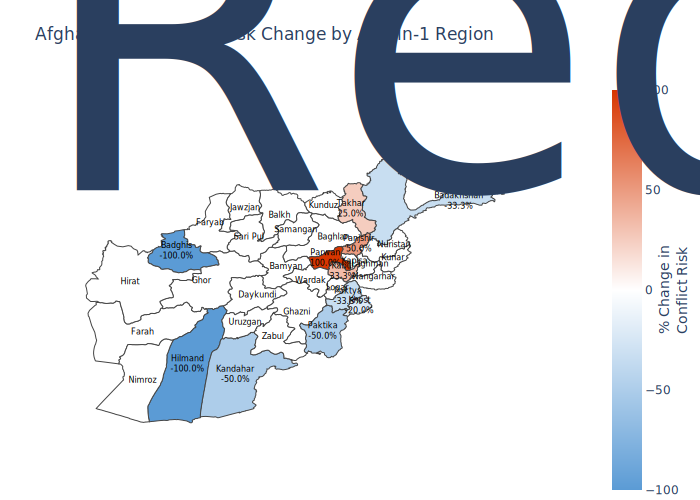

In [12]:
import plotly.io as pio
#pio.renderers.default = "browser"       # opens in your web browser
pio.renderers.default = "svg"        # or PNG/SVG/JSON if you prefer
fig.show()


In [17]:
# Save the interactive plot in multiple formats
from datetime import datetime
import os

# Create output directory if it doesn't exist
output_dir = r"C:\Users\matia\OneDrive\Escritorio\Nastia_BSE\Master_Thesis\UN_Conflict_Report\graphrag_pipeline\data\images"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y-%m-%d")
base_filename = f"Map_{country.replace(' ', '_')}_{timestamp}"

# Save as HTML (interactive)
html_file = os.path.join(output_dir, f"{base_filename}.html")
fig.write_html(html_file)

# Save as PDF (static, high quality)
pdf_file = os.path.join(output_dir, f"{base_filename}.pdf")
fig.write_image(pdf_file, width=1200, height=800)

# Save as SVG (vector format)
svg_file = os.path.join(output_dir, f"{base_filename}.svg")
fig.write_image(svg_file, width=1200, height=800)

print(f"All files saved in: {os.path.abspath(output_dir)}")

All files saved in: C:\Users\matia\OneDrive\Escritorio\Nastia_BSE\Master_Thesis\UN_Conflict_Report\graphrag_pipeline\data\images


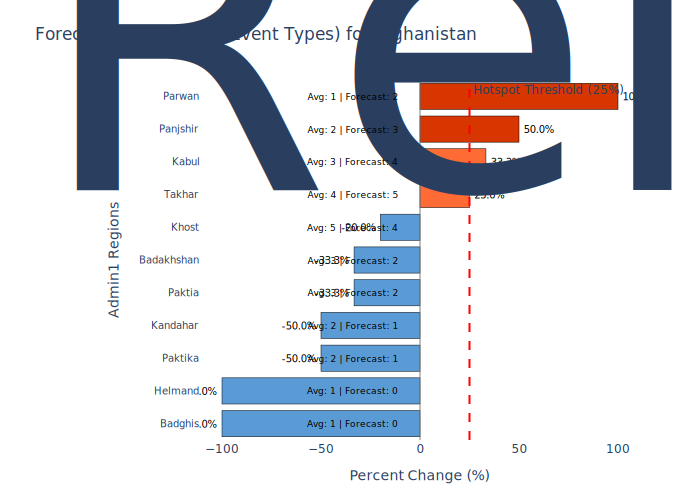

In [24]:
def create_tabular_chart(final_merged_df: gpd.GeoDataFrame, country: str) -> go.Figure:
    """
    Create a horizontal bar chart showing forecasted events data with percent_increase1, avg1, and total_forecast values.
    
    Args:
        final_merged_df: Merged GeoDataFrame with all data
        country: Country name
    
    Returns:
        Plotly Figure object with horizontal bar chart
    """
    # Filter only regions with data and sort by percent_increase1 descending
    df_filtered = final_merged_df[
        (final_merged_df['admin1'].notna()) & 
        (final_merged_df['percent_increase1'] != 0)
    ].copy()
    
    if len(df_filtered) == 0:
        print("No data available for tabular chart")
        return go.Figure()
    
    # Sort by percent_increase1 in descending order (for y-axis positioning)
    df_sorted = df_filtered.sort_values('percent_increase1', ascending=True)  # ascending for proper horizontal order
    
    # Prepare data for the bar chart
    admin_names = df_sorted['admin1'].tolist()
    forecast_values = df_sorted['total_forecast'].round(0).astype(int).tolist()
    average_values = df_sorted['avg1'].round(0).astype(int).tolist()
    percent_changes = df_sorted['percent_increase1'].round(1).tolist()
    
    # Create color mapping for bars (similar to the original table styling)
    colors = []
    for pct in percent_changes:
        if pct >= 50:
            colors.append('#d73600')  # Dark red for high increases
        elif pct >= 25:
            colors.append('#ff6b35')  # Orange-red for moderate increases
        elif pct >= 0:
            colors.append('#ffd700')  # Yellow for small increases
        else:
            colors.append('#5b9bd5')  # Blue for decreases
    
    # Create the horizontal bar chart
    fig = go.Figure()
    
    # Create custom text for each bar showing all three values
    bar_text = []
    for i, admin in enumerate(admin_names):
        text = f"{admin}<br>Avg: {average_values[i]} | Forecast: {forecast_values[i]} | Change: {percent_changes[i]}%"
        bar_text.append(text)
    
    fig.add_trace(go.Bar(
        y=admin_names,
        x=percent_changes,
        orientation='h',
        marker=dict(
            color=colors,
            line=dict(color='black', width=0.5)
        ),
        text=[f"{pct}%" for pct in percent_changes],
        textposition='outside',
        textfont=dict(size=10, color='black'),
        hovertemplate=(
            "<b>%{y}</b><br>"
            "Percent Change: %{x:.1f}%<br>"
            "Average Events: %{customdata[0]}<br>"
            "Forecasted Events: %{customdata[1]}"
            "<extra></extra>"
        ),
        customdata=list(zip(average_values, forecast_values)),
        name="Percent Change"
    ))
    
    # Add text annotations for avg1 and total_forecast values
    for i, admin in enumerate(admin_names):
        # Position text at the left side of the chart for all values
        fig.add_annotation(
            y=admin,
            x=-10,  # Position to the left of the chart
            text=f"Avg: {average_values[i]} | Forecast: {forecast_values[i]}",
            showarrow=False,
            font=dict(size=9, color='black'),
            xanchor='right',
            yanchor='middle'
        )
    
    # Update layout
    fig.update_layout(
        title=f"Forecasted Events (All Event Types) for {country}<br>"
              f"<sub>Relative to 1-Month Average - Sorted by Risk Level</sub>",
        xaxis_title="Percent Change (%)",
        yaxis_title="Admin1 Regions",
        font=dict(size=12),
        margin=dict(l=200, r=60, t=80, b=60),  # Increased left margin for annotations
        height=max(1000, len(df_sorted) * 40 + 200),
        paper_bgcolor='white',
        plot_bgcolor='white',
        showlegend=False
    )
    
    # Update y-axis for better readability
    fig.update_yaxes(
        tickfont=dict(size=10)
    )
    
    # Add vertical line at 25% (hotspot threshold)
    fig.add_vline(
        x=25, 
        line_dash="dash", 
        line_color="red", 
        annotation_text="Hotspot Threshold (25%)",
        annotation_position="top right"
    )
    
    # Add vertical line at 0% (neutral line)
    fig.add_vline(
        x=0, 
        line_dash="solid", 
        line_color="gray", 
        line_width=1
    )
    
    return fig

# Create the tabular chart using the function defined earlier
fig_tabular = create_tabular_chart(final_merged_df, country)

# Show the plot
fig_tabular.show()